In [15]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import spotipy
import sqlite3
from sklearn.cluster import KMeans
from sqlite3 import Error
import seaborn as sns
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
import time
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from openTSNE import TSNE as openTSNE
from wordcloud import WordCloud
from wordcloud import STOPWORDS as STOPWORDS

In [4]:
def connect_db(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

In [87]:
# connect to database
conn = connect_db('data.db')
cur = conn.cursor()

In [88]:
# Getting the target data
# Extract playlists that have the input words in their titles to use as training data
input_words = ['summer', 'beach', 'throwbacks']
# sql_select = '''SELECT AVG(danceability), AVG(energy), AVG(key), AVG(loudness), 
# AVG(mode), AVG(speechiness), AVG(acousticness), AVG(instrumentalness), AVG(liveness), 
# AVG(valence), AVG(tempo), AVG(duration_ms), AVG(time_signature) FROM avg_features_by_playlist WHERE'''

sql_select = '''SELECT * FROM avg_features_by_playlist WHERE'''
for w in range(len(input_words)):
    sql_select += " name LIKE '%" + input_words[w] + "%'"
    if w != len(input_words) -1:
        sql_select += " OR" 
pl_train = cur.execute(sql_select).fetchall()


In [89]:
# Get X data (average playlist features)
data_cols = ['pid', 'name', 'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
feature_cols = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
test_cols = ['pid', 'name', 'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']

data_rows = cur.execute('select * from avg_features_by_playlist where pid > (select MIN(pid) from avg_features_by_playlist) order by pid').fetchall()


# test_pl = cur.execute('''select tracks_in_playlist.pid, tracks_in_playlist.track_uri, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature 
# from features_by_track left join tracks_in_playlist on
# features_by_track.track_uri = tracks_in_playlist.track_uri 
# where pid = (select MIN(pid) from avg_features_by_playlist)''').fetchall()


test_data = pd.DataFrame(pl_train, columns=test_cols)
data = pd.DataFrame(data_rows, columns=data_cols)

print(test_data.head())
print(data.head(5))

   pid             name  danceability    energy  key   loudness  mode  \
0    0       Throwbacks      0.664077  0.781077  0.0  -4.891212   0.0   
1  115            beach      0.658866  0.728402  0.0  -6.430356   0.0   
2  125           summer      0.677868  0.703642  0.0  -5.698415   0.0   
3  169     Summer Chill      0.646425  0.506537  0.0 -10.315649   0.0   
4  181  Summer Playlist      0.591926  0.603926  0.0  -6.992222   0.0   

   speechiness  acousticness  instrumentalness  liveness   valence  \
0     0.103698      0.083674          0.000674  0.187087  0.642750   
1     0.093119      0.166368          0.005590  0.197189  0.673794   
2     0.202636      0.139387          0.000211  0.226962  0.632208   
3     0.112705      0.350255          0.209132  0.147148  0.487011   
4     0.084893      0.161321          0.002425  0.162344  0.336756   

        tempo    duration_ms  time_signature  
0  121.157500  221777.461538        4.000000  
1  118.341402  223320.860825        3.979381  

In [90]:
conn.close()

In [91]:
# Scale the data


y = test_data[feature_cols].mean()

scaler = StandardScaler(with_mean=True, with_std=True).fit(data[feature_cols].values)

scaled_x = scaler.transform(data[feature_cols].values)
scaled_y = scaler.transform(np.array(y).reshape(1,-1))
scaled_features = pd.DataFrame(scaled_x)
tsne = openTSNE(perplexity=30, metric='euclidean', n_jobs=-1, random_state=0, verbose=False)
tsne_transformer = tsne.fit(scaled_x)
data_df = pd.DataFrame(tsne_transformer.transform(scaled_x), columns =['X', 'Y'])

print(data_df)

              X          Y
0     21.276732  21.568135
1    -20.246433  -8.423200
2     20.031665   0.665362
3      7.362819   3.134238
4    -27.012925  15.421020
...         ...        ...
1994 -10.356884  36.625469
1995 -37.257642 -17.268461
1996  17.318788  25.430585
1997   7.362140  -1.852427
1998  -5.309760  30.023337

[1999 rows x 2 columns]


<AxesSubplot:xlabel='X', ylabel='Y'>

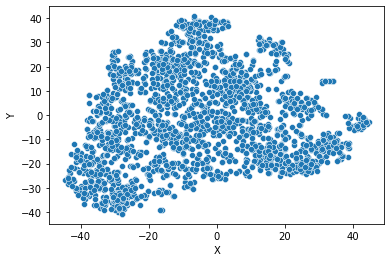

In [92]:
sns.scatterplot(x='X', y='Y', data=data_df, legend=None)

In [93]:
# initialize KMeans
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit(scaled_x)
labels = clusters.labels_
data_df['cluster'] = pd.Categorical(labels)

target_cluster = kmeans.predict(scaled_y)
print(target_cluster)


[9]


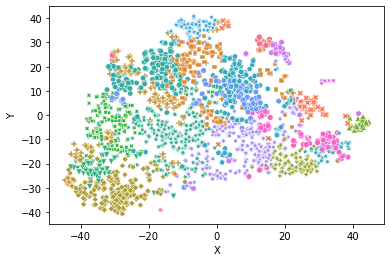

In [94]:
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=data_df, legend=None)
plt.show()

In [95]:
data_df

,X,Y,cluster
0,21.276732,21.568135,16
1,-20.246433,-8.423200,9
2,20.031665,0.665362,15
3,7.362819,3.134238,2
4,-27.012925,15.421020,7
...,...,...,...
1994,-10.356884,36.625469,13
1995,-37.257642,-17.268461,4
1996,17.318788,25.430585,16
1997,7.362140,-1.852427,12


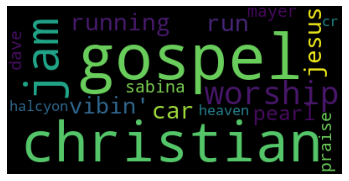

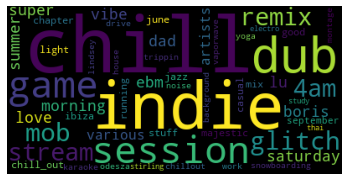

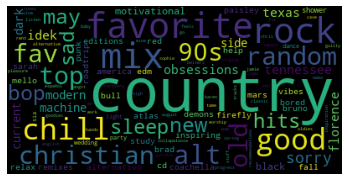

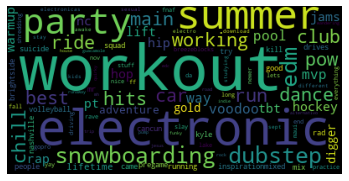

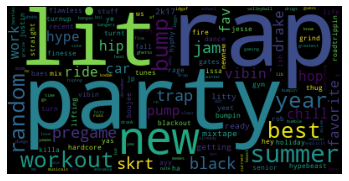

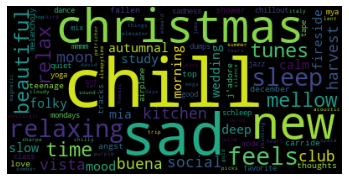

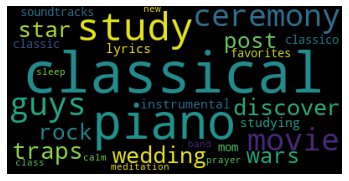

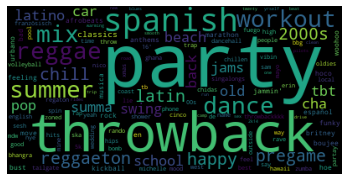

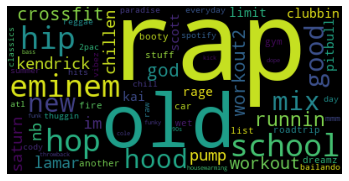

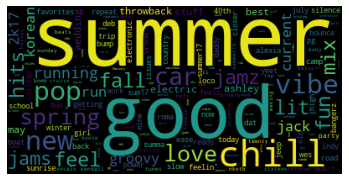

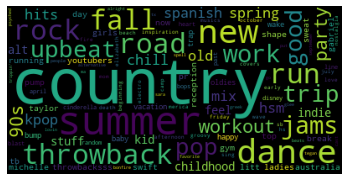

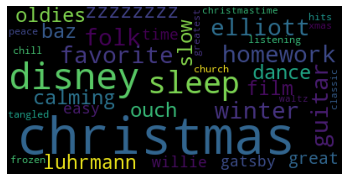

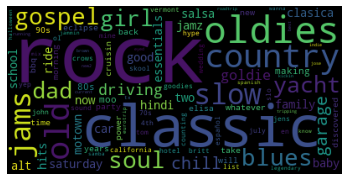

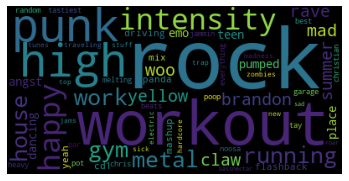

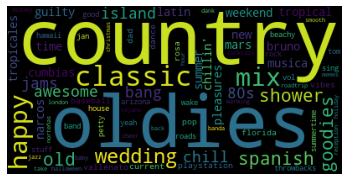

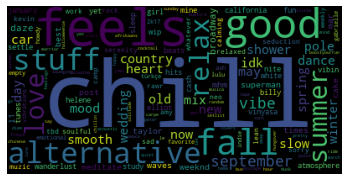

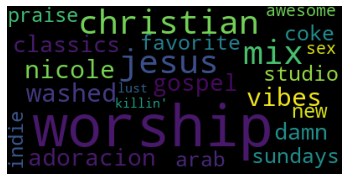

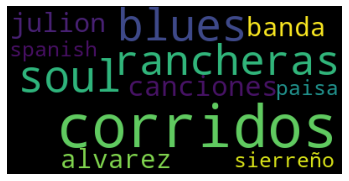

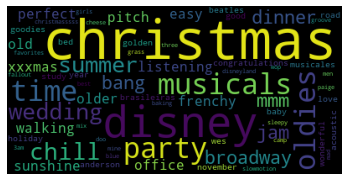

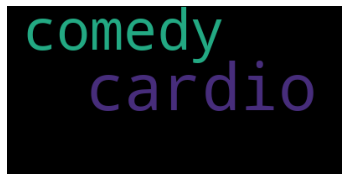

In [96]:
data_df["playlist_name"] = data['name'].str.lower()
# display(data_df)

# we want to perform a pivot on data_df so that each cluster number is a column with row value equal to the playlist name.
# from there we can sum up that column to get the whole lsit of strings of playlist names for each cluster (column)
original_df = data_df.pivot(index='X', columns='cluster')['playlist_name'].reset_index()
original_df.columns.name = None
original_df = original_df.fillna('')
# original_df.head(20)
# print(original_df.columns)

#list of words to ignore
stop_words = STOPWORDS.update(["i", "it", "me", "my", "that", "the", "of", "than", "then", 
"when", "if", "a", "there", "playlist", "music", "song", "songs", "to", "too", "get", "as", "this", 
"am", "is", "are", "has", "and", "aa", "aaa", 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 
'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

wordclouds = {}
for i in range(n_clusters):
    original_df.replace(np.nan, '')
    original_df[i] = original_df[i].astype(str) #.sum(skipna=True))
    wordclouds["wordcloud" + str(i)] = WordCloud(stopwords=stop_words).generate(' '.join(original_df[i]))

for val in wordclouds.values():
    plt.imshow(val)
    plt.axis("off")
    plt.show()


In [66]:
type(original_df[0][0])



float